# setup

In [1]:
import os

if os.getcwd().split('/')[-1] == 'notebooks':
    os.chdir('..')

In [2]:
import torch
import torch.nn as nn

from models.baseline import ResnetBaseline
from hparams import BATCH_SIZE, NUM_WORKERS

In [3]:
model_label = 'code15'
from runners.multiclass import Runner
from dataloaders.code15 import CODE as DS
from dataloaders.code15 import CODEsplit as DSsplit
model = ResnetBaseline(n_classes = 6)
model = torch.load('output/{}/{}.pt'.format(model_label, model_label))

output_col = ['1dAVb', 'RBBB', 'LBBB', 'SB', 'AF', 'ST']

In [4]:
from dataloaders.codetest import CODEtest
from utils import json_dump

# init

In [5]:
database = DS(metadata_path = '/home/josegfer/datasets/code/output/metadata.csv')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
runner = Runner(device = device, model = model, database = database, split = DSsplit, model_label = model_label, output_col = output_col)

# run

In [7]:
tst_ds = CODEtest()
val_dl = torch.utils.data.DataLoader(runner.val_ds, batch_size = BATCH_SIZE, 
                                     shuffle = False, num_workers = NUM_WORKERS)
tst_dl = torch.utils.data.DataLoader(tst_ds, batch_size = BATCH_SIZE, 
                                     shuffle = False, num_workers = NUM_WORKERS)

In [8]:
best_f1s, best_thresholds = runner._synthesis(val_dl, best_thresholds = None)
all_binary_results, all_true_labels, metrics_dict = runner._synthesis(tst_dl, best_thresholds)
metrics_dict

  0%|          | 0/97 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00, 10.55it/s]


{'Accuracy': [0.9866989117291415,
  0.9915356711003628,
  0.992744860943168,
  0.992744860943168,
  0.9939540507859734,
  0.9842805320435308,
  0.9540507859733979],
 'F1 Score': [0.7555555555555554,
  0.8955223880597014,
  0.888888888888889,
  0.8333333333333334,
  0.8,
  0.7999999999999999,
  0.9725036179450072],
 'AUC ROC': [0.8035714285714286,
  0.9392849195163564,
  0.9,
  0.9656673859432798,
  0.8833868833868834,
  0.8500855285665412,
  0.8940770019914309]}

# gradcam

In [75]:
class ResnetHook(nn.Module):
    def __init__(self, model):
        super(ResnetHook, self).__init__()
        self.model = model
        self.gradients = None
    
    def activations_hook(self, grad):
        self.gradients = grad
    
    def forward(self, x):
        x = self.model.input_layer(x)

        h = x.register_hook(self.activations_hook)

        x = self.model.residual_blocks(x)

        # h = x.register_hook(self.activations_hook)

        x = self.model.flatten(x)
        logits = self.model.linear(x)
        return logits

    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        x = self.model.input_layer(x)
        # x = self.model.residual_blocks(x)
        return x

In [76]:
explain = ResnetHook(runner.model)
explain.eval()

ResnetHook(
  (model): ResnetBaseline(
    (input_layer): Sequential(
      (0): Conv1d(12, 64, kernel_size=(17,), stride=(4,), padding=(7,), bias=False)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv1d(64, 64, kernel_size=(17,), stride=(1,), padding=(8,))
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Dropout(p=0.2, inplace=False)
      (7): Conv1d(64, 64, kernel_size=(17,), stride=(1,), padding=(8,))
      (8): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): Dropout(p=0.2, inplace=False)
    )
    (residual_blocks): StackedResidual(
      (blocks): ModuleList(
        (0): ResidualBlock(
          (first_branch): Sequential(
            (0): Conv1d(64, 128, kernel_size=(17,), stride=(1,), padding=(8,))
            (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [85]:
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np

# from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
# from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget, RawScoresOutputTarget

from utils import get_inputs

In [150]:
leads = ['DI', 'DII', 'DIII', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

In [78]:
for batch in (tst_dl):
    break

In [228]:
np.where(batch['y'][:, 2] == 1)

(array([  1,  15,  18,  28,  58,  91,  99, 104]),)

In [207]:
def plot_explain(ecg, heatmaplow):
    ecg = ecg.cpu()
    n = ecg.shape[-1]
    heatmap = np.maximum(signal.resample(heatmaplow, n), 0)

    nrows = 6
    ncols = 2
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (48, 24));
    for j in range(ncols):
        for i in range(nrows):
            axes[i, j].plot(ecg[0, i+j*nrows, :]);
            axes[i, j].set_title(leads[i+j*nrows]);
            axes[i, j].set_xticks([]);

            axes[i, j].scatter(np.arange(n), np.zeros(n), c = heatmap, cmap = 'Reds', 
                marker = '|', s = 1e6, linewidths = 0.5);
            axes[i, j].set_xlim((0, n));

## 1dAVb

In [208]:
idx = 12
raw = batch['x'][idx:idx+1, :, :]
label = batch['y'][idx:idx+1, :]
ecg = get_inputs(raw, device = device)
label = label.to(device).float()

# logits = model.forward(ecg)
logits = explain.forward(ecg)
label, logits

(tensor([[1., 0., 0., 0., 0., 0.]], device='cuda:0'),
 tensor([[ -0.5698,  -9.0519,  -8.1450,  -9.6643, -10.5959, -11.3338]],
        device='cuda:0', grad_fn=<AddmmBackward>))

In [209]:
logits[:, 0].backward()
gradients = explain.get_activations_gradient()
pooled_gradients = torch.mean(gradients, dim=[0, 2])

activations = explain.get_activations(ecg).detach()
for i in range(activations.shape[1]):
    activations[:, i, :] *= pooled_gradients[i]
heatmapraw = torch.mean(activations, dim=1).squeeze().cpu()
heatmaplow = nn.functional.relu(heatmapraw)
heatmaplow /= torch.max(heatmaplow)

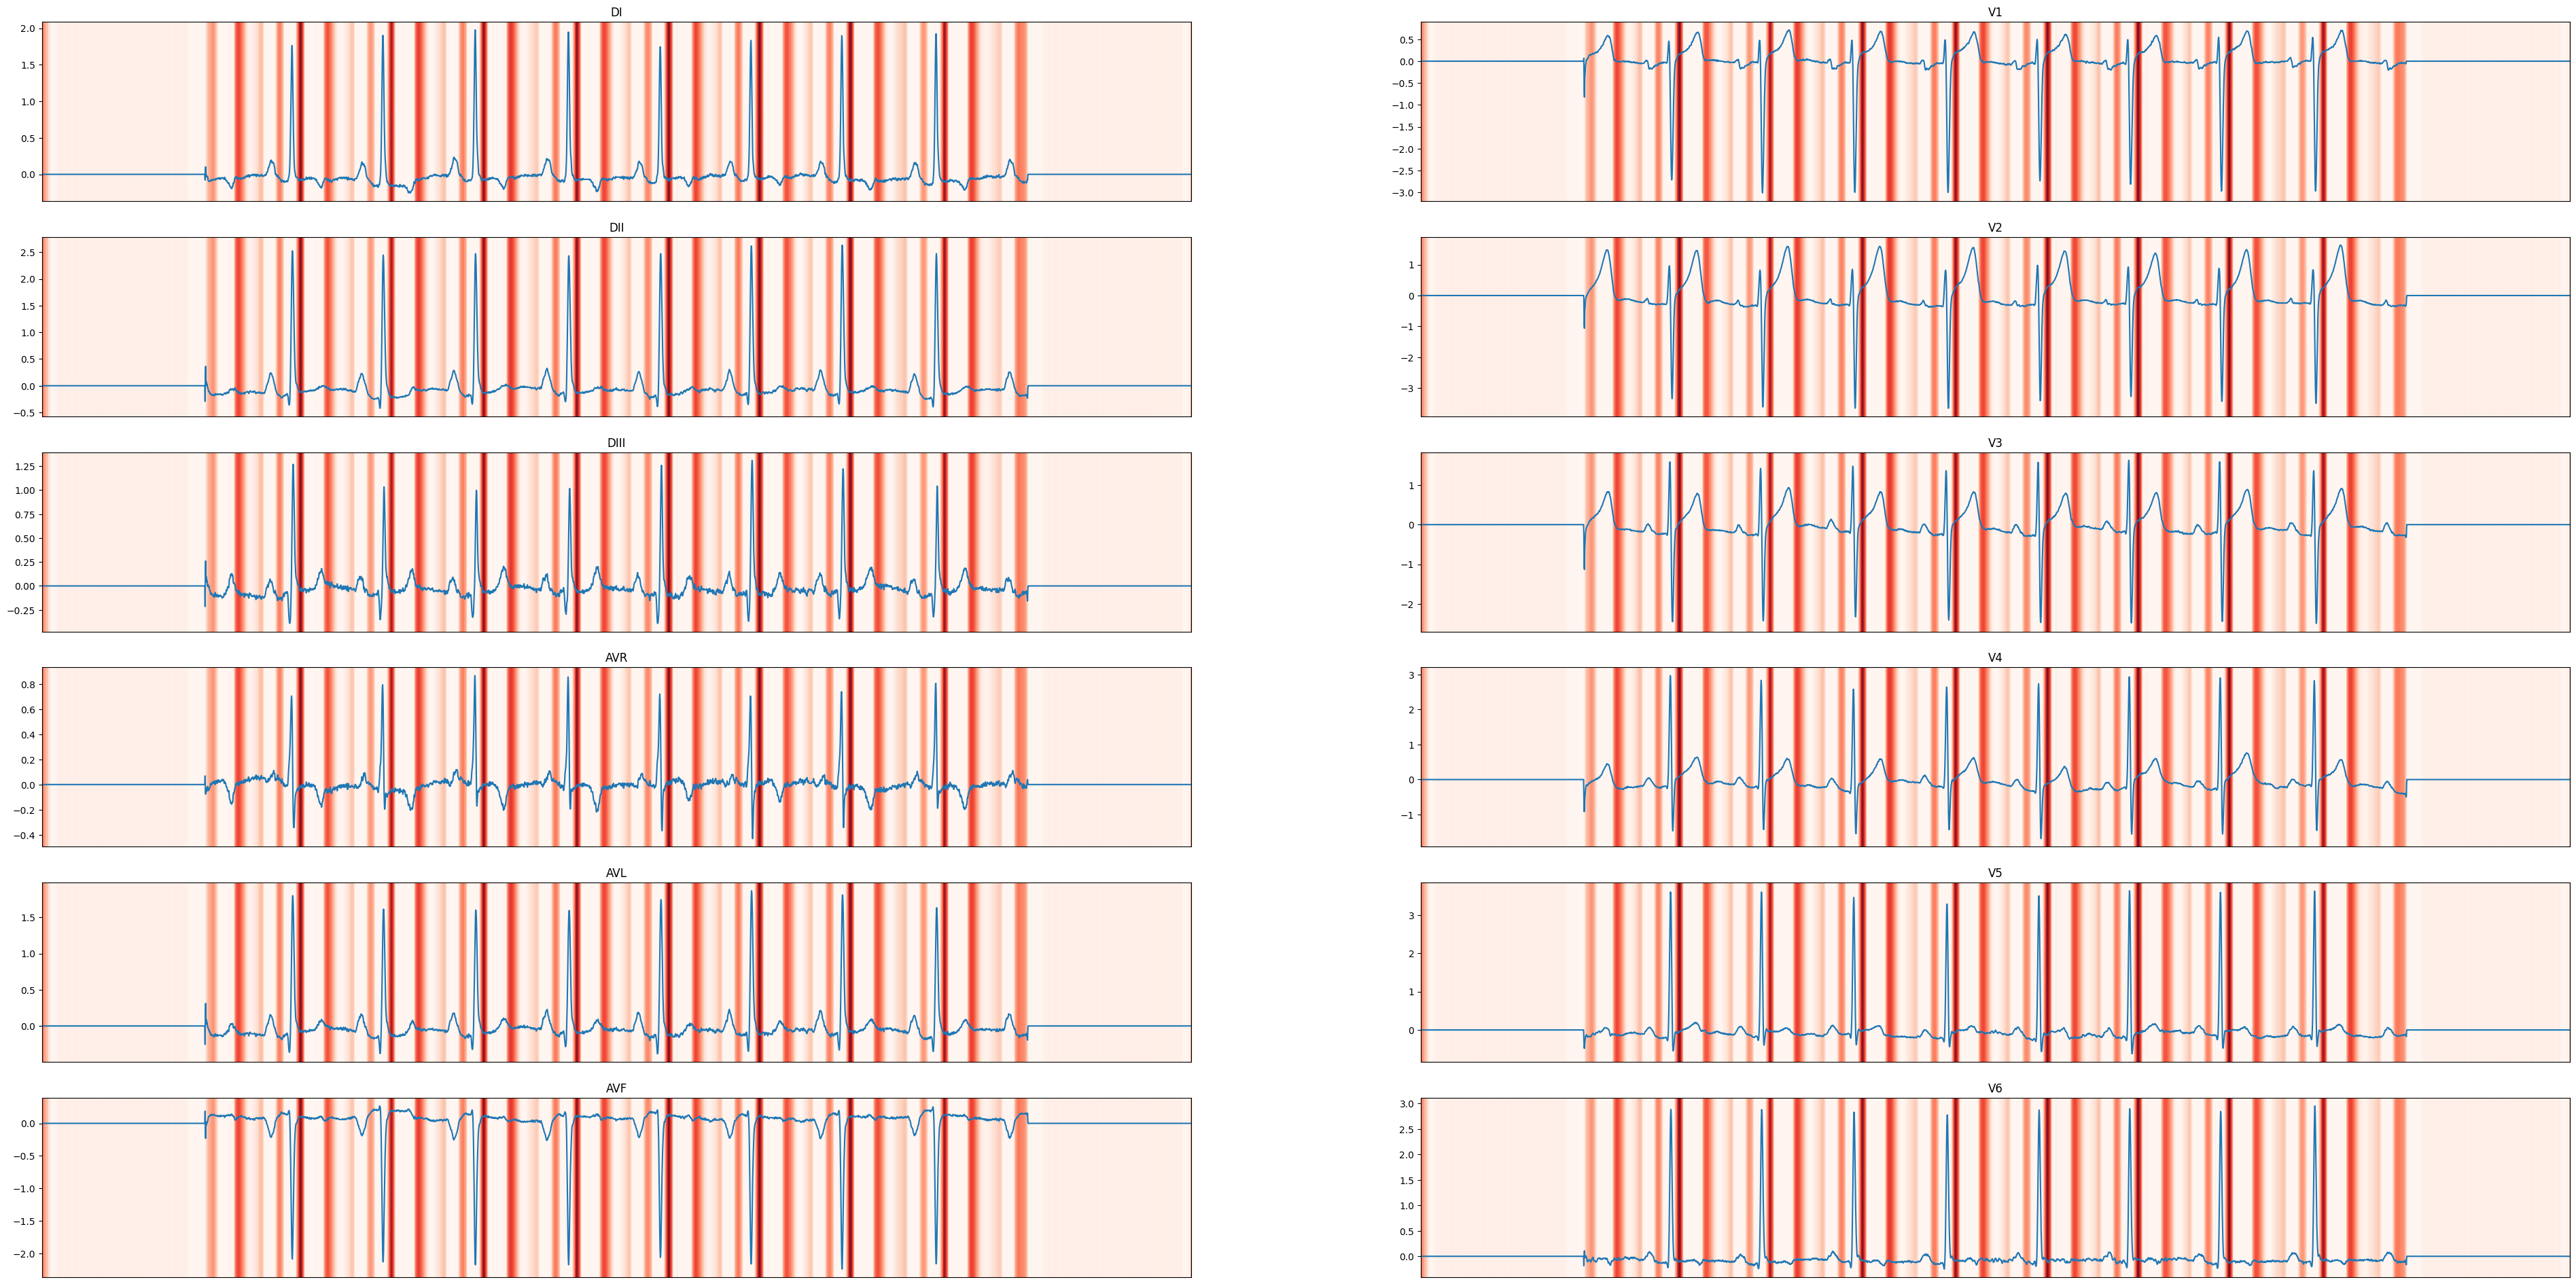

In [210]:
plot_explain(ecg, heatmaplow)

## RBBB

In [211]:
idx = 106
raw = batch['x'][idx:idx+1, :, :]
label = batch['y'][idx:idx+1, :]
ecg = get_inputs(raw, device = device)
label = label.to(device).float()

# logits = model.forward(ecg)
logits = explain.forward(ecg)
label, logits

(tensor([[0., 1., 0., 0., 0., 0.]], device='cuda:0'),
 tensor([[ -7.3217,   1.3322,  -5.2444,  -8.2005,  -8.7239, -11.6114]],
        device='cuda:0', grad_fn=<AddmmBackward>))

In [212]:
logits[:, 1].backward()
gradients = explain.get_activations_gradient()
pooled_gradients = torch.mean(gradients, dim=[0, 2])

activations = explain.get_activations(ecg).detach()
for i in range(activations.shape[1]):
    activations[:, i, :] *= pooled_gradients[i]
heatmapraw = torch.mean(activations, dim=1).squeeze().cpu()
heatmaplow = nn.functional.relu(heatmapraw)
heatmaplow /= torch.max(heatmaplow)

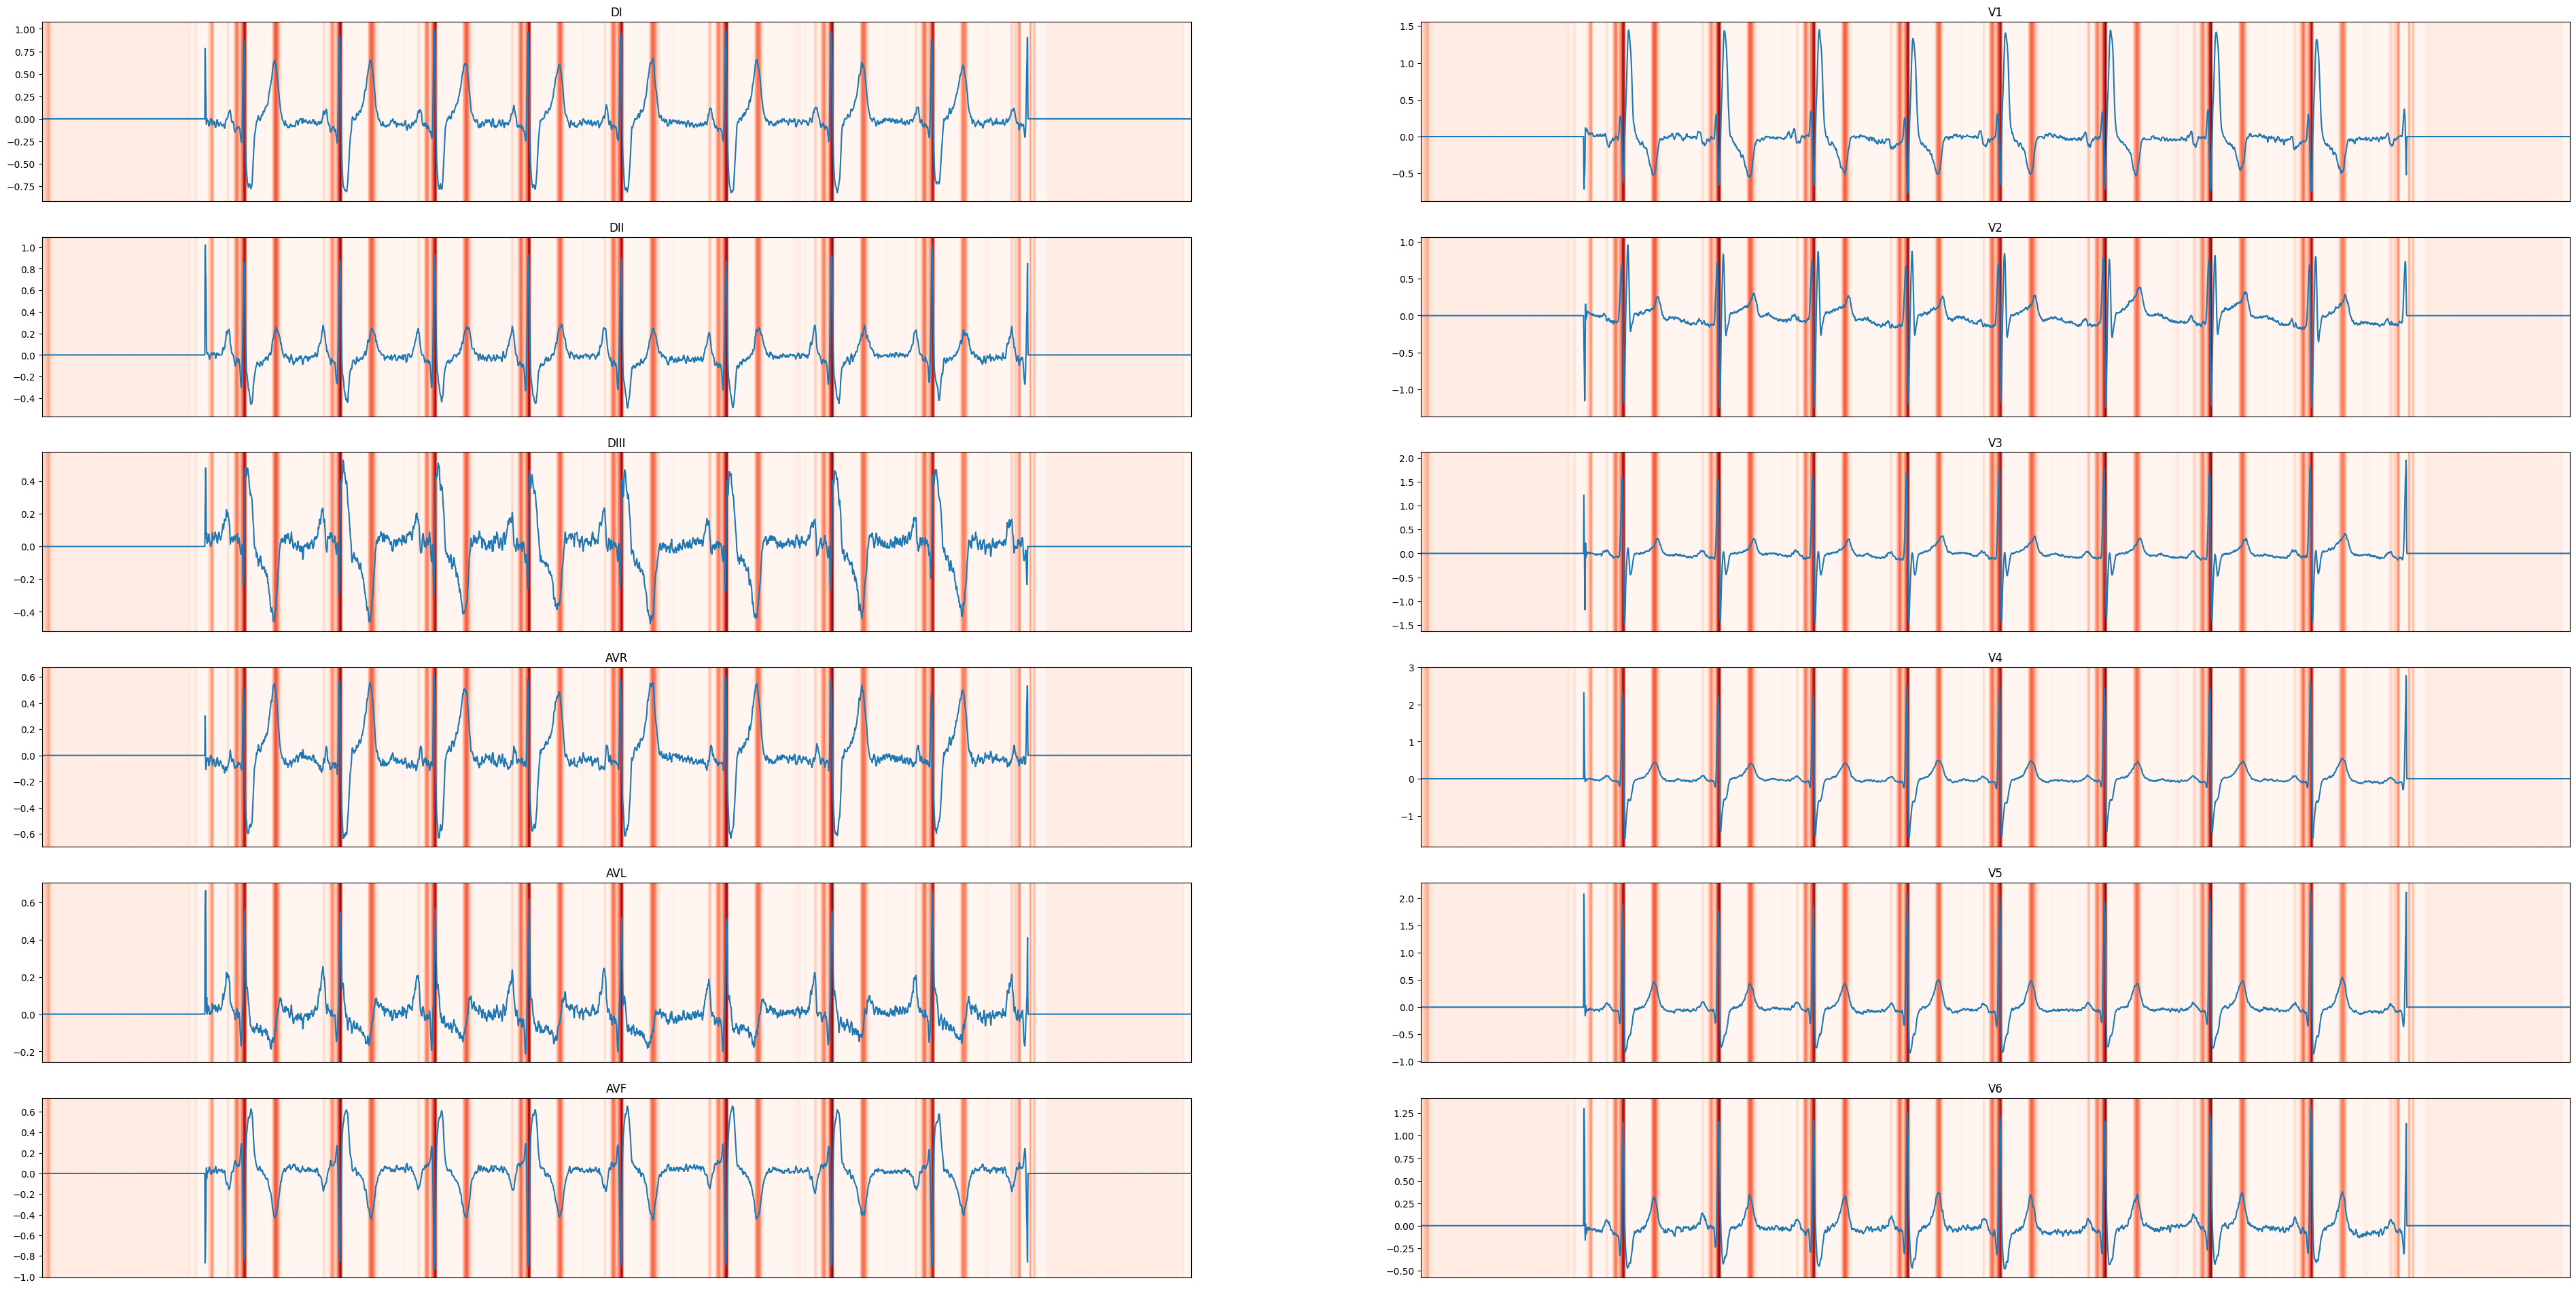

In [213]:
plot_explain(ecg, heatmaplow)

## LBBB

In [236]:
idx = 99
raw = batch['x'][idx:idx+1, :, :]
label = batch['y'][idx:idx+1, :]
ecg = get_inputs(raw, device = device)
label = label.to(device).float()

# logits = model.forward(ecg)
logits = explain.forward(ecg)
label, logits

(tensor([[0., 0., 1., 0., 0., 0.]], device='cuda:0'),
 tensor([[-6.1697, -6.1668,  2.1711, -8.4102, -6.2067, -8.0548]],
        device='cuda:0', grad_fn=<AddmmBackward>))

In [237]:
logits[:, 2].backward()
gradients = explain.get_activations_gradient()
pooled_gradients = torch.mean(gradients, dim=[0, 2])

activations = explain.get_activations(ecg).detach()
for i in range(activations.shape[1]):
    activations[:, i, :] *= pooled_gradients[i]
heatmapraw = torch.mean(activations, dim=1).squeeze().cpu()
heatmaplow = nn.functional.relu(heatmapraw)
heatmaplow /= torch.max(heatmaplow)

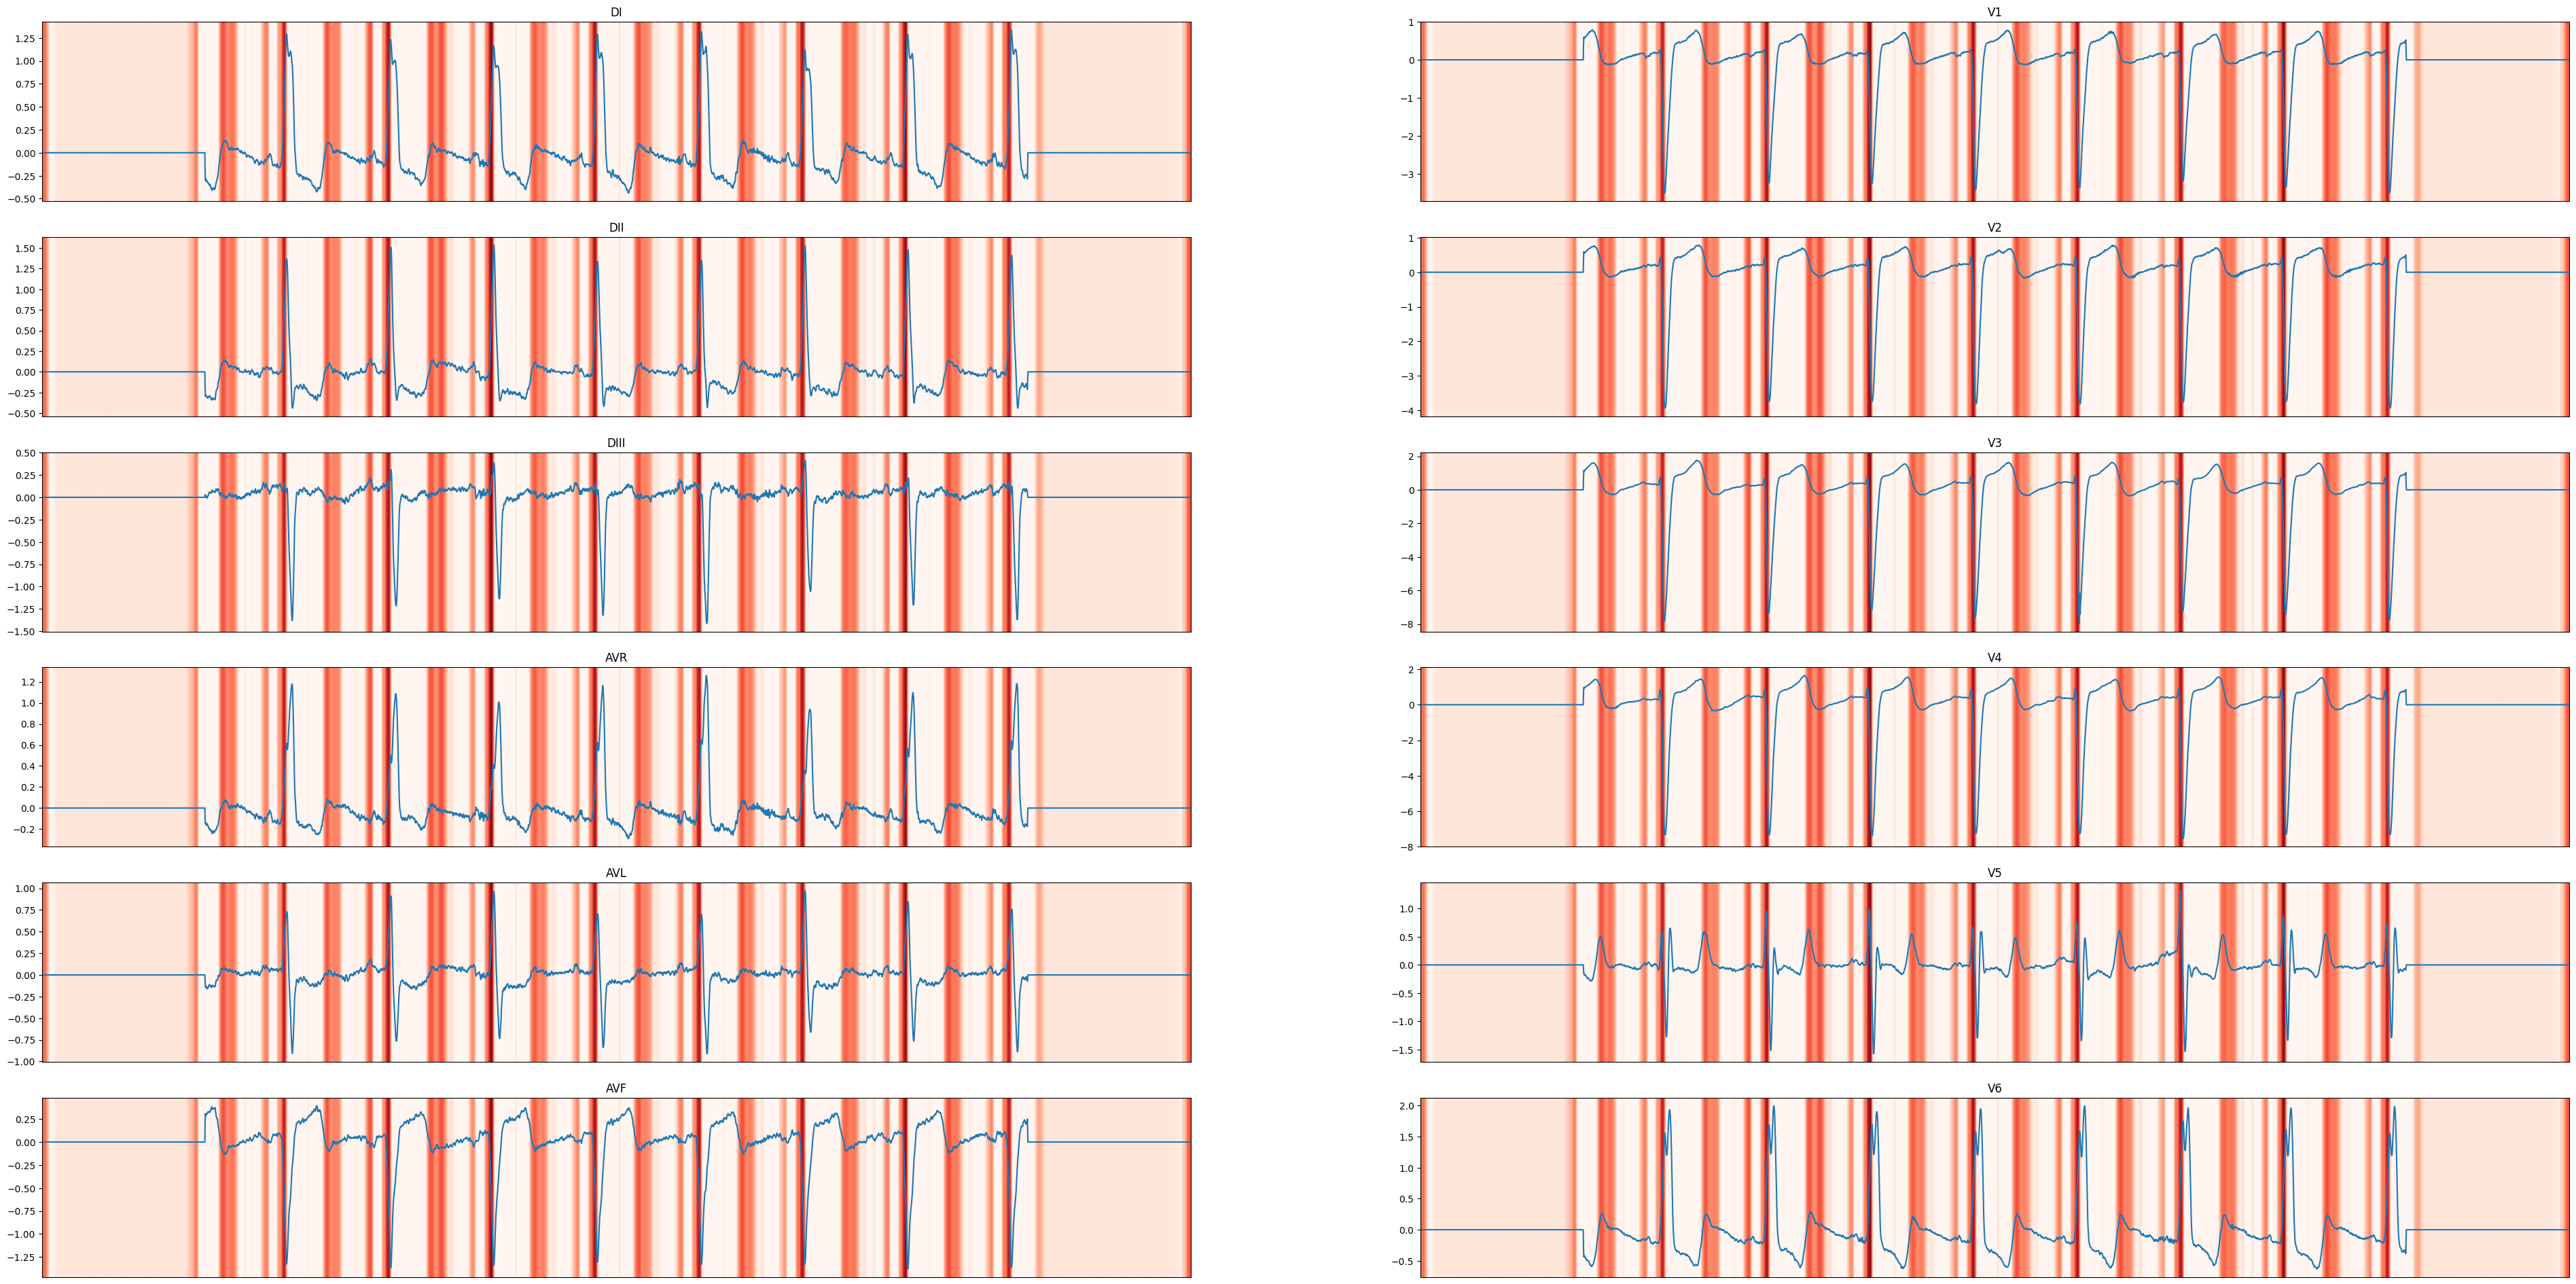

In [238]:
plot_explain(ecg, heatmaplow)

In [217]:
# print(ecg.shape)
# x = model.input_layer(ecg)
# print(x.shape)
# x = model.residual_blocks(x)
# print(x.shape)
# x = model.flatten(x)
# print(x.shape)
# x = model.linear(x)
# print(x.shape)

## SB

In [239]:
idx = 40
raw = batch['x'][idx:idx+1, :, :]
label = batch['y'][idx:idx+1, :]
ecg = get_inputs(raw, device = device)
label = label.to(device).float()

# logits = model.forward(ecg)
logits = explain.forward(ecg)
label, logits

(tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0'),
 tensor([[ -4.4256,  -3.1646,  -8.5502,  -0.5401,  -2.7337, -10.3970]],
        device='cuda:0', grad_fn=<AddmmBackward>))

In [240]:
logits[:, 3].backward()
gradients = explain.get_activations_gradient()
pooled_gradients = torch.mean(gradients, dim=[0, 2])

activations = explain.get_activations(ecg).detach()
for i in range(activations.shape[1]):
    activations[:, i, :] *= pooled_gradients[i]
heatmapraw = torch.mean(activations, dim=1).squeeze().cpu()
heatmaplow = nn.functional.relu(heatmapraw)
heatmaplow /= torch.max(heatmaplow)

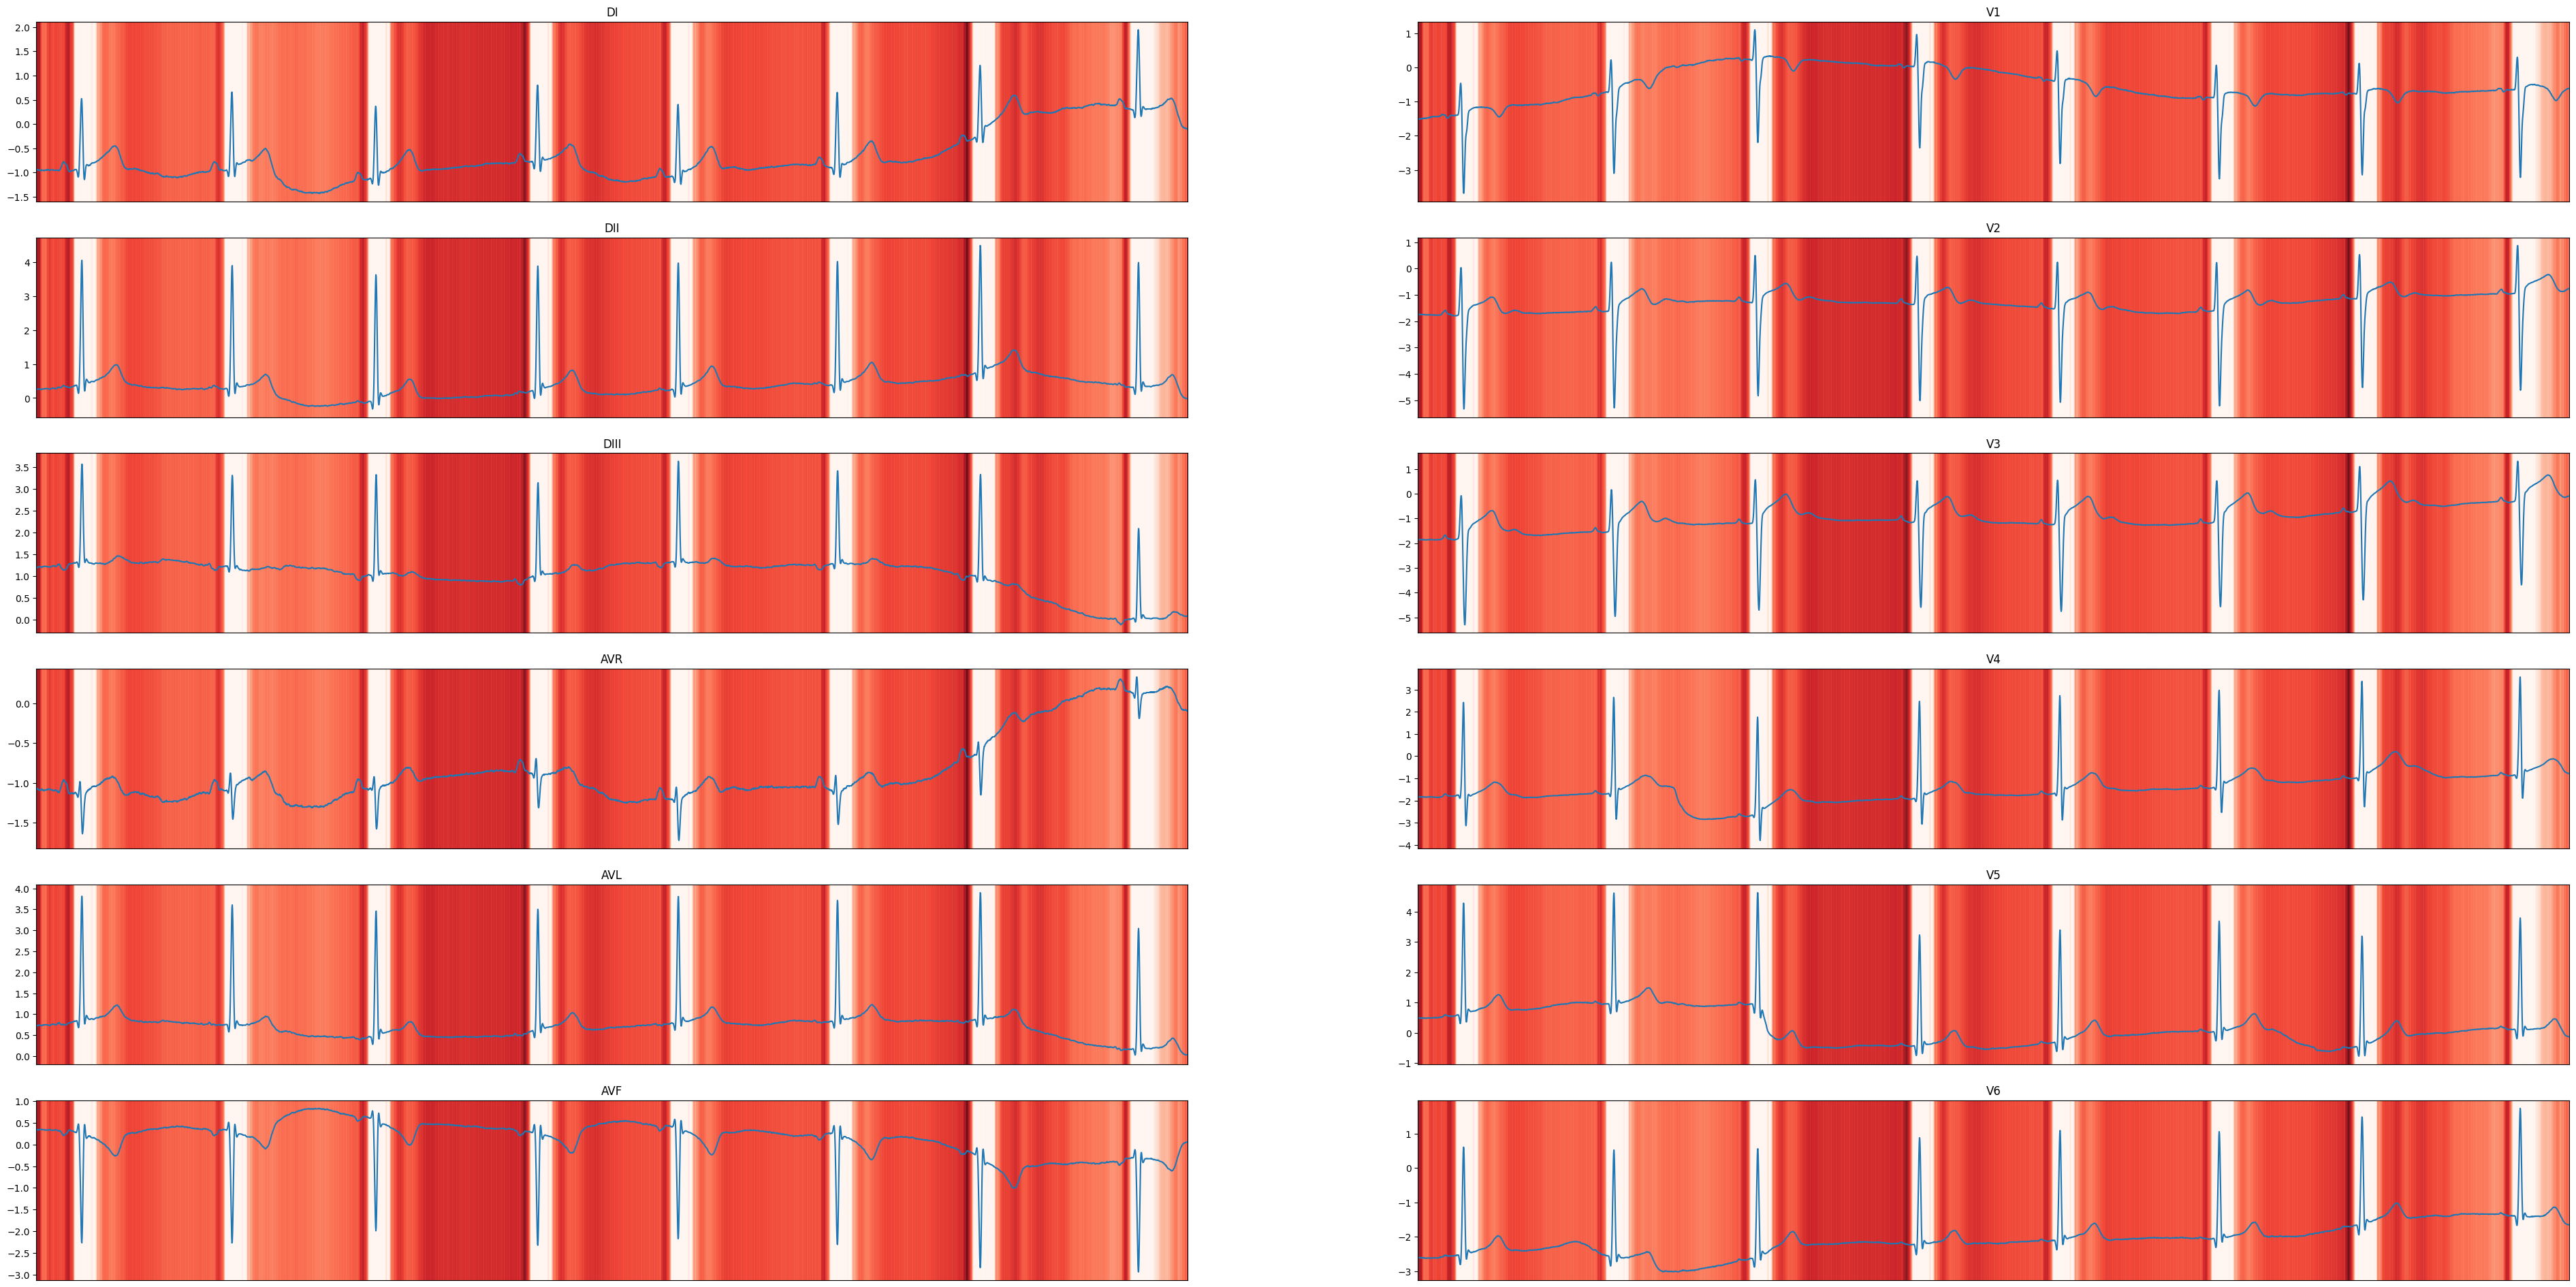

In [241]:
plot_explain(ecg, heatmaplow)

## AF

In [221]:
idx = 120
raw = batch['x'][idx:idx+1, :, :]
label = batch['y'][idx:idx+1, :]
ecg = get_inputs(raw, device = device)
label = label.to(device).float()

# logits = model.forward(ecg)
logits = explain.forward(ecg)
label, logits

(tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0'),
 tensor([[-5.2738, -5.8627, -7.5046, -8.8451,  2.1079, -9.3973]],
        device='cuda:0', grad_fn=<AddmmBackward>))

In [222]:
logits[:, 4].backward()
gradients = explain.get_activations_gradient()
pooled_gradients = torch.mean(gradients, dim=[0, 2])

activations = explain.get_activations(ecg).detach()
for i in range(activations.shape[1]):
    activations[:, i, :] *= pooled_gradients[i]
heatmapraw = torch.mean(activations, dim=1).squeeze().cpu()
heatmaplow = nn.functional.relu(heatmapraw)
heatmaplow /= torch.max(heatmaplow)

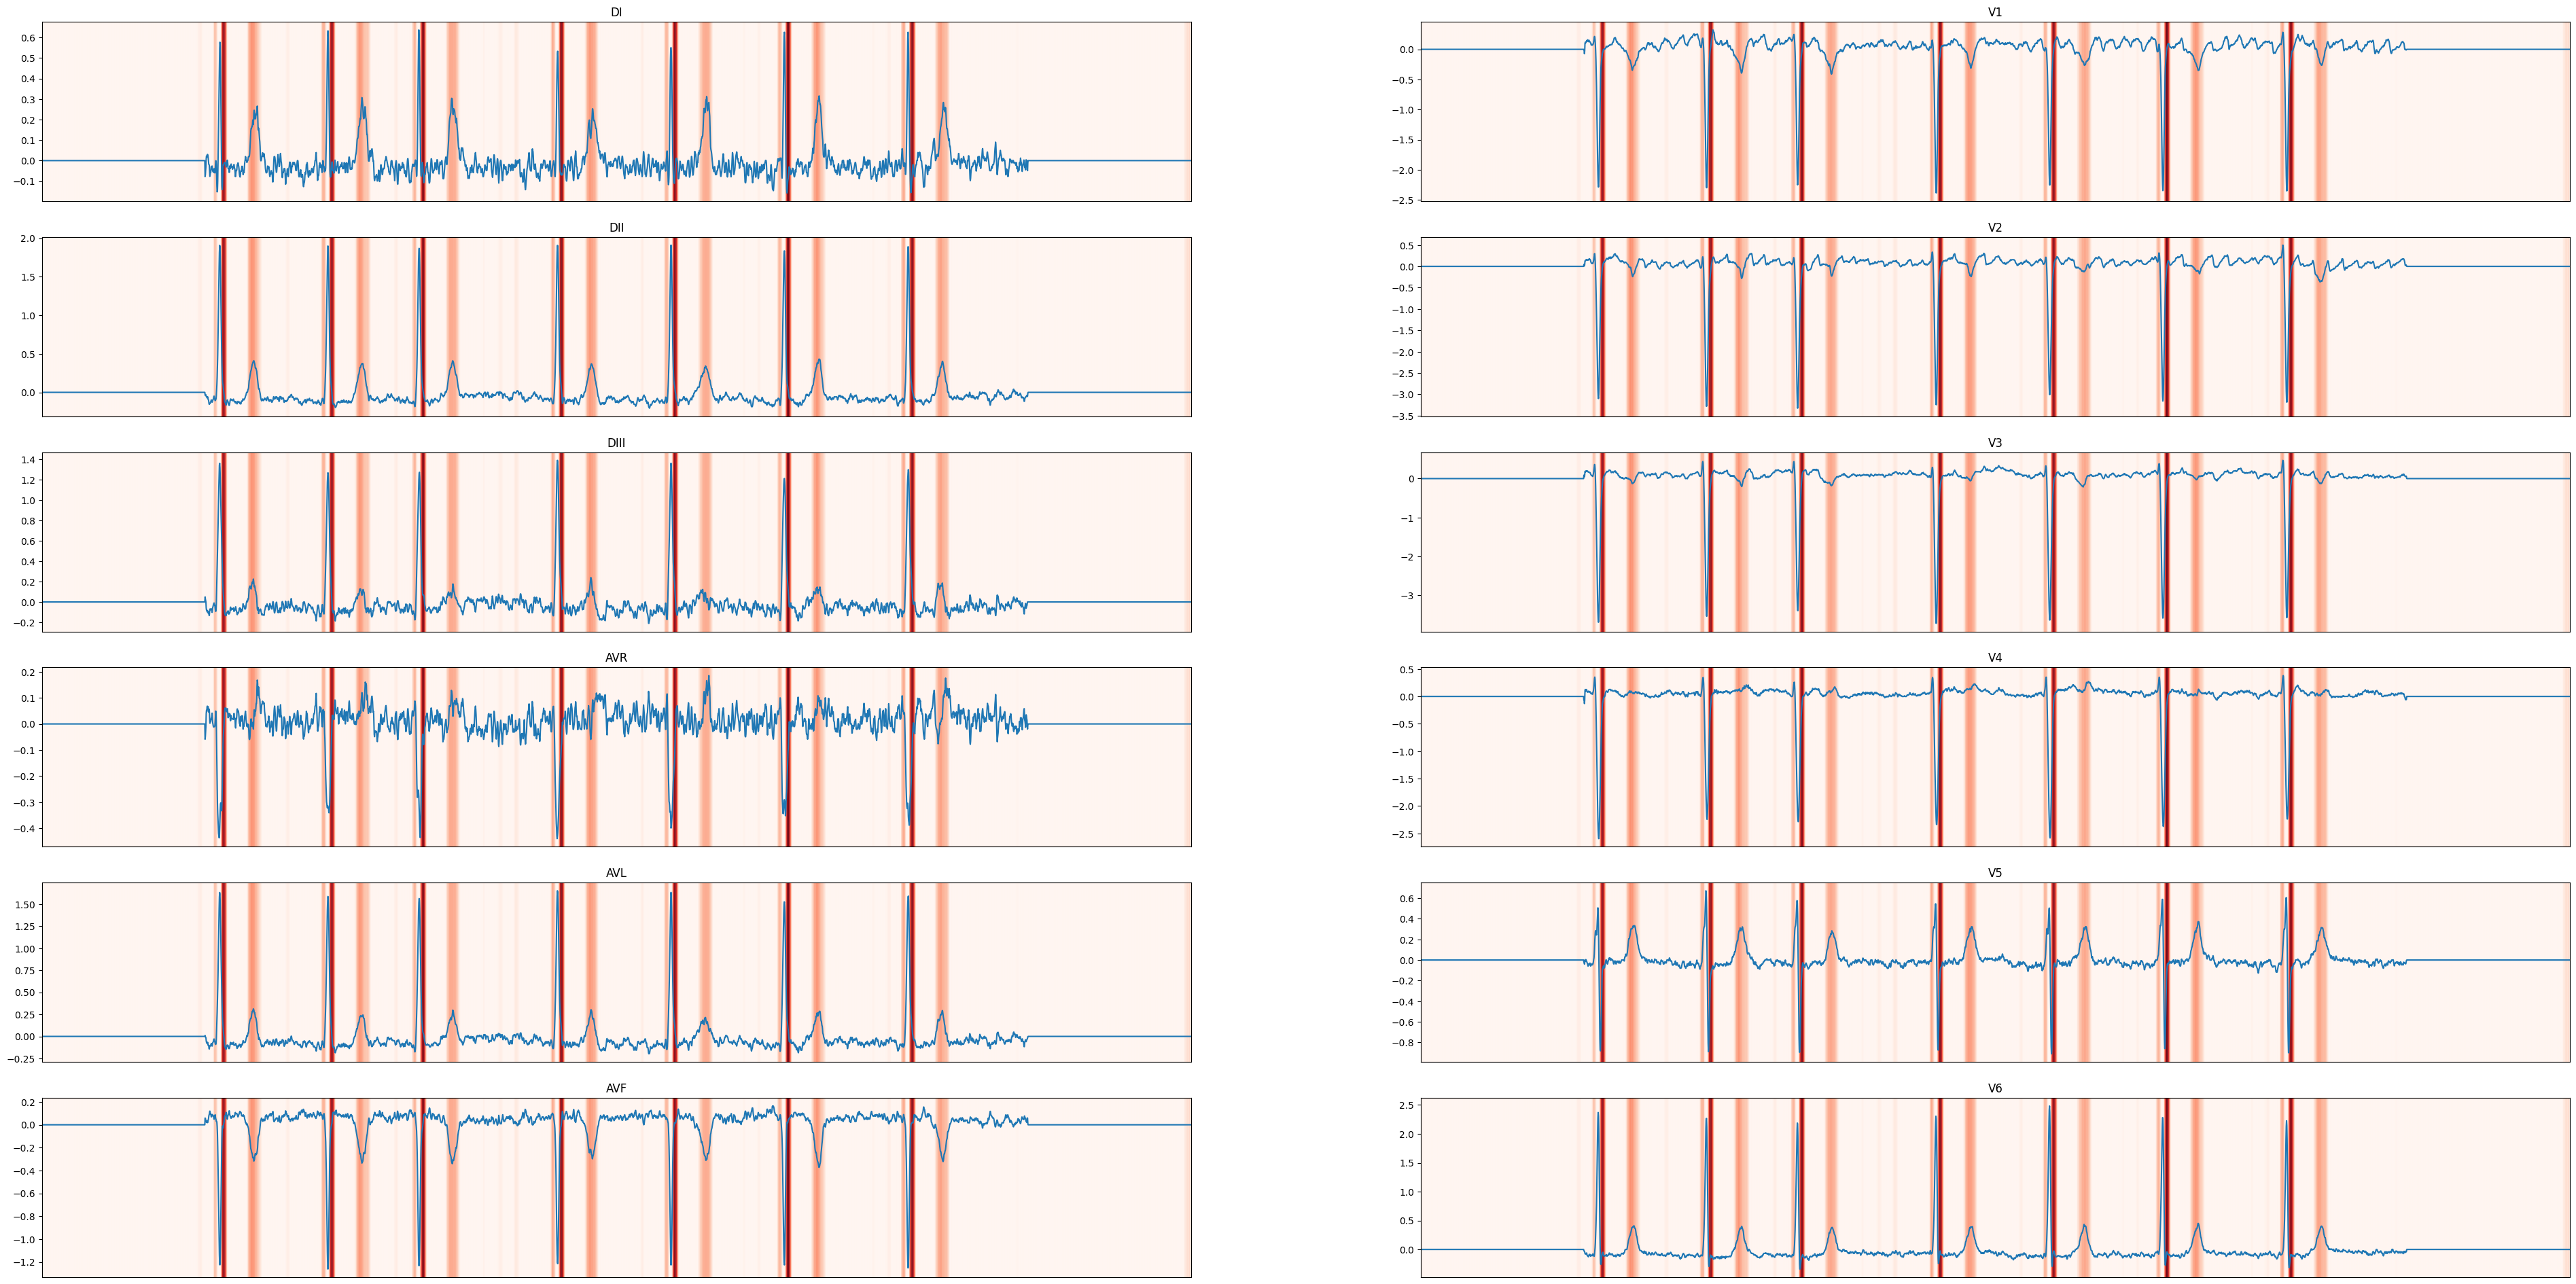

In [223]:
plot_explain(ecg, heatmaplow)

## ST

In [224]:
idx = 33
raw = batch['x'][idx:idx+1, :, :]
label = batch['y'][idx:idx+1, :]
ecg = get_inputs(raw, device = device)
label = label.to(device).float()

# logits = model.forward(ecg)
logits = explain.forward(ecg)
label, logits

(tensor([[0., 0., 0., 0., 0., 1.]], device='cuda:0'),
 tensor([[-8.3993, -9.0330, -8.5026, -8.7310, -4.4254, -0.0547]],
        device='cuda:0', grad_fn=<AddmmBackward>))

In [225]:
logits[:, 5].backward()
gradients = explain.get_activations_gradient()
pooled_gradients = torch.mean(gradients, dim=[0, 2])

activations = explain.get_activations(ecg).detach()
for i in range(activations.shape[1]):
    activations[:, i, :] *= pooled_gradients[i]
heatmapraw = torch.mean(activations, dim=1).squeeze().cpu()
heatmaplow = nn.functional.relu(heatmapraw)
heatmaplow /= torch.max(heatmaplow)

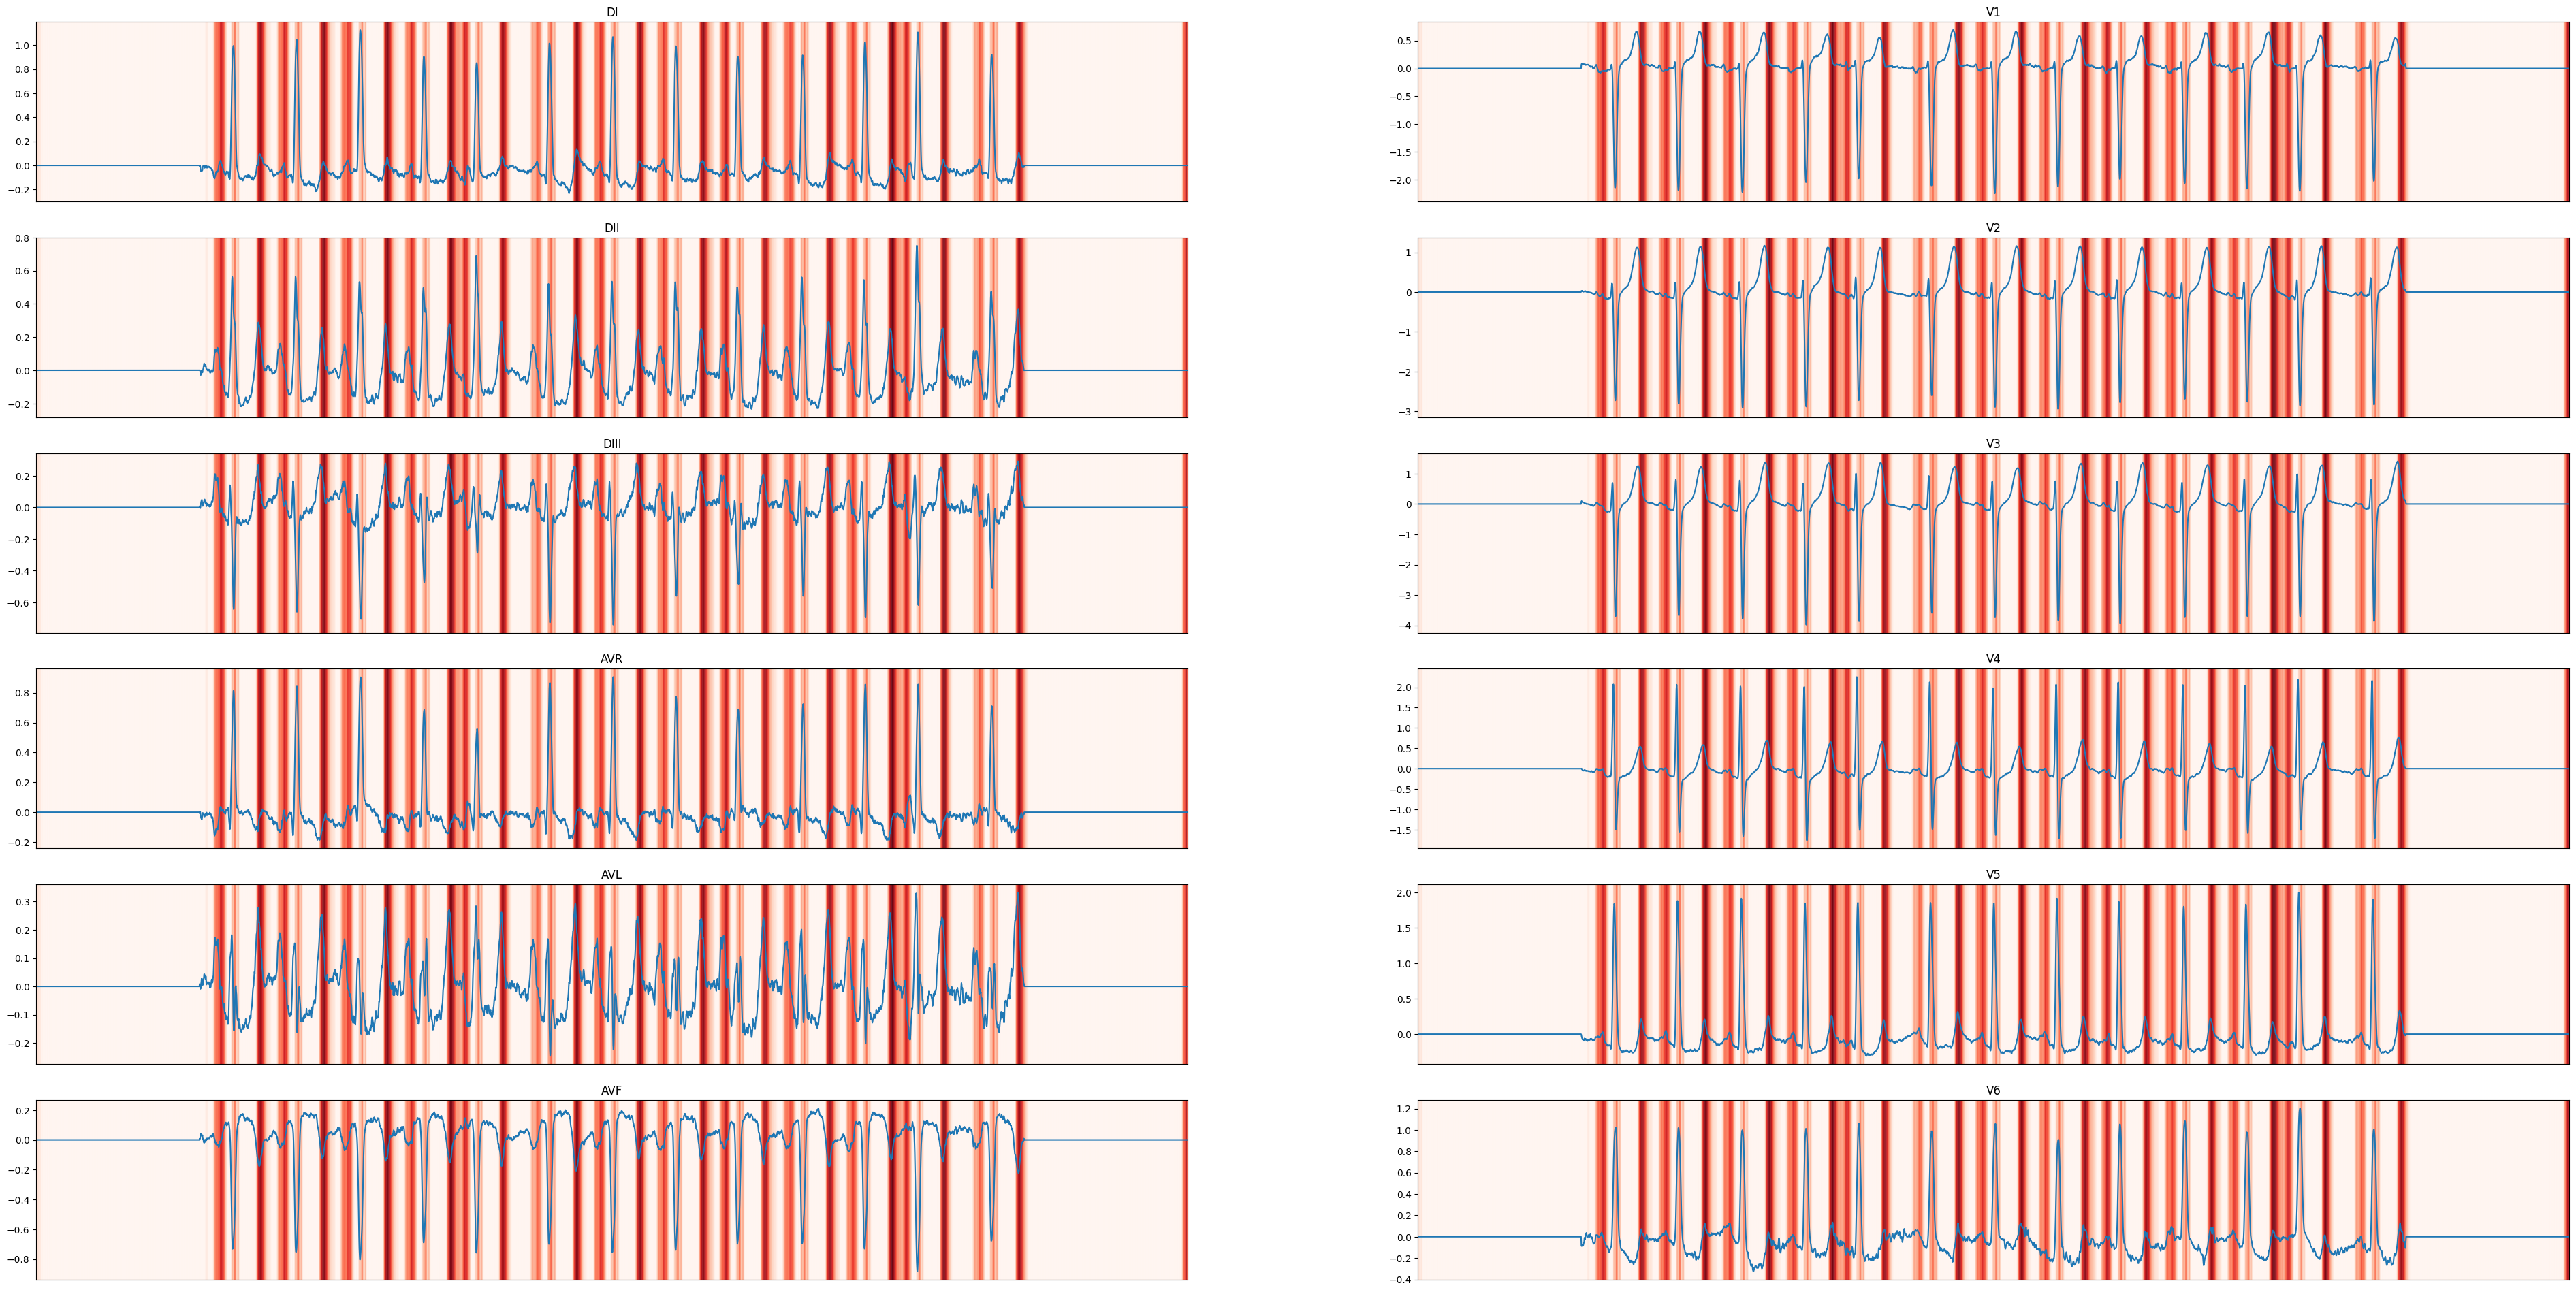

In [226]:
plot_explain(ecg, heatmaplow)